In [1]:
!pip install "numpy<2.0"

Defaulting to user installation because normal site-packages is not writeable


# Task 4: Text Data - Fake News Detection
**Student Name:** [Your Name]
**Module:** Artificial Intelligence Coursework (MOD004553)

## Objective
To build and compare Machine Learning models for detecting fake news. This notebook covers:
1.  **Data Preprocessing:** Cleaning text and removing noise.
2.  **Classic ML:** Logistic Regression & Naïve Bayes (TF-IDF).
3.  **Deep Learning:** Fine-tuning a DistilBERT Transformer.
4.  **Unsupervised Learning:** LDA Topic Modelling.
5.  **Explainability:** Feature importance analysis.

In [2]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords

# Download stopwords (common words like "the", "is", "in" that we remove)
nltk.download('stopwords')

def load_and_clean_data():
    # 1. Load the datasets
    # Ensure these file paths match where you saved your files
    fake_df = pd.read_csv('C:\\Users\\LAPTOPS HUB\\OneDrive\\Desktop\\text analysis\\nlp\\Fake.csv')
    real_df = pd.read_csv('C:\\Users\\LAPTOPS HUB\\OneDrive\\Desktop\\text analysis\\nlp\\True.csv')

    # 2. Assign Labels
    # We use 1 for Fake and 0 for Real (Standard binary classification convention)
    fake_df['label'] = 1
    real_df['label'] = 0

    # 3. Merge and Shuffle
    # Concatenate both dataframes
    data = pd.concat([fake_df, real_df], axis=0)
    
    # Shuffle the data so the model doesn't learn order (e.g., all Fakes first)
    data = data.sample(frac=1).reset_index(drop=True)
    
    # 4. Drop unnecessary columns
    # 'title' and 'subject' might be useful, but for now we often focus on 'text'
    # You can also combine title and text: data['text'] = data['title'] + " " + data['text']
    data = data[['text', 'label']]

    return data

def clean_text(text):
    '''
    Standard text cleaning function for NLP
    '''
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs (http/https/www)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove user @ references and '#' from tweet-like data (good practice)
    text = re.sub(r'\@\w+|\#','', text)
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove stopwords (optional but recommended for Classic ML)
    stop_words = set(stopwords.words('english'))
    text = " ".join([word for word in text.split() if word not in stop_words])
    
    return text



[nltk_data] Downloading package stopwords to C:\Users\LAPTOPS
[nltk_data]     HUB\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# --- EXECUTION ---

# Load Data
print("Loading data...")
df = load_and_clean_data()
print(f"Dataset Loaded. Total Records: {df.shape[0]}")

# Apply Cleaning (This may take a minute due to dataset size)
print("Cleaning text (this may take a moment)...")
df['clean_text'] = df['text'].apply(clean_text)

# Preview
print("\nData Preview:")
print(df[['text', 'clean_text', 'label']].head())

# Save to CSV (optional, so you don't have to clean every time)
# df.to_csv('cleaned_news_data.csv', index=False)

Loading data...
Dataset Loaded. Total Records: 44898
Cleaning text (this may take a moment)...

Data Preview:
                                                text  \
0  21st Century Wire says At some point, the poli...   
1  Mental health professionals will now be allowe...   
2  BRASILIA (Reuters) - Former Brazilian senator ...   
3  LA CELLE-SAINT-CLOUD/PARIS (Reuters) - A Frenc...   
4  You might remember a few months ago, the Berni...   

                                          clean_text  label  
0  21st century wire says point political theatri...      1  
1  mental health professionals allowed openly dia...      1  
2  brasilia reuters former brazilian senator envi...      0  
3  la cellesaintcloudparis reuters frenchbacked w...      0  
4  might remember months ago bernie sanders campa...      1  


## Step 2: Classical Machine Learning
**What happens here:**
* **TF-IDF Vectorization:** We convert the text into numbers based on word frequency. Rare but important words get a higher score.
* **Model Training:** We train two baseline models:
    1.  **Logistic Regression:** A simple, fast, and explainable linear model.
    2.  **Naïve Bayes:** A probabilistic model often used for text classification.
* **Evaluation:** We check accuracy and plot a confusion matrix to see where errors happen.

Vectorizing text (this may take a moment)...
Training Logistic Regression...
Training Naive Bayes...
--- Logistic Regression Results ---
Accuracy: 0.9896
ROC-AUC: 0.9989

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4286
           1       0.99      0.99      0.99      4694

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



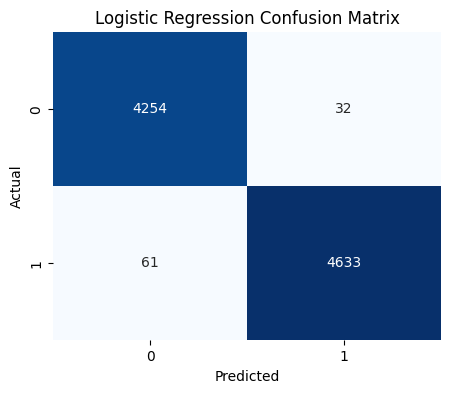

--- Naive Bayes Results ---
Accuracy: 0.9433
ROC-AUC: 0.9843

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      4286
           1       0.95      0.94      0.95      4694

    accuracy                           0.94      8980
   macro avg       0.94      0.94      0.94      8980
weighted avg       0.94      0.94      0.94      8980



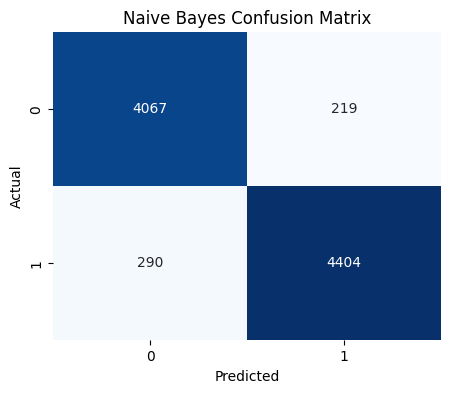

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Split Data ---
# We use the 'clean_text' column we created in Step 1
X = df['clean_text']
y = df['label']

# Split: 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 2. TF-IDF Vectorization ---
print("Vectorizing text (this may take a moment)...")
# max_features=5000 limits us to the top 5k most frequent words to keep it fast
tfidf = TfidfVectorizer(max_features=5000) 

# Fit on training data ONLY, then transform both train and test
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# --- 3. Train Models ---
# Model A: Logistic Regression (Standard baseline)
print("Training Logistic Regression...")
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)

# Model B: Naive Bayes (Very good for text classification)
print("Training Naive Bayes...")
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

# --- 4. Evaluation Function ---
def evaluate_model(model, X_test_feat, y_test, model_name):
    y_pred = model.predict(X_test_feat)
    y_prob = model.predict_proba(X_test_feat)[:, 1] # Probability for ROC-AUC
    
    print(f"--- {model_name} Results ---")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"ROC-AUC: {roc_auc_score(y_test, y_prob):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Run Evaluation
evaluate_model(lr_model, X_test_tfidf, y_test, "Logistic Regression")
evaluate_model(nb_model, X_test_tfidf, y_test, "Naive Bayes")

In [5]:
!pip install --force-reinstall h5py

Defaulting to user installation because normal site-packages is not writeable
  Using cached h5py-3.15.1-cp312-cp312-win_amd64.whl.metadata (3.1 kB)
  Using cached numpy-2.3.5-cp312-cp312-win_amd64.whl.metadata (60 kB)
Using cached h5py-3.15.1-cp312-cp312-win_amd64.whl (2.9 MB)
Using cached numpy-2.3.5-cp312-cp312-win_amd64.whl (12.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: h5py
    Found existing installation: h5py 3.15.1
    Uninstalling h5py-3.15.1:
      Successfully uninstalled h5py-3.15.1


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mediapipe 0.10.21 requires numpy<2, but you have numpy 2.3.5 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.5 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.5 which is incompatible.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.3.5 which is incompatible.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.16.2 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.3.5 which is incompatible.
streamlit 1.37.1 requires

In [6]:
!pip uninstall -y tensorflow tensorflow-intel

In [7]:
!pip install "numpy<2.0"

Defaulting to user installation because normal site-packages is not writeable
  Using cached numpy-1.26.4-cp312-cp312-win_amd64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-win_amd64.whl (15.5 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.3.5
    Uninstalling numpy-2.3.5:
      Successfully uninstalled numpy-2.3.5


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.16.2 which is incompatible.
streamlit 1.37.1 requires packaging<25,>=20, but you have packaging 25.0 which is incompatible.
streamlit 1.37.1 requires pillow<11,>=7.1.0, but you have pillow 12.0.0 which is incompatible.


In [8]:
!pip install "accelerate>=0.26.0"

Defaulting to user installation because normal site-packages is not writeable


## Step 3: Deep Learning (DistilBERT Fine-Tuning)
**What happens here:**
* **Data Preparation:** We select a subset of the data (e.g., 2,000 samples) to ensure the code runs quickly on a standard computer. We then split this into training and testing sets.
* **Tokenization:** We use the `DistilBertTokenizer` to convert our raw text into numerical "tokens" that the DistilBERT model understands.
* **Dataset Creation:** We wrap the tokenized data into a custom PyTorch `Dataset` class. This organizes the data into batches for the model.
* **Model Loading:** We load a pre-trained **DistilBERT** model from Hugging Face. This model has already been trained on massive amounts of English text (Transfer Learning).
* **Fine-Tuning:** We use the `Trainer` API to slightly adjust (fine-tune) the model's weights specifically for our Fake News detection task over 1 epoch.
* **Evaluation:** Finally, we calculate metrics like Accuracy and F1-score to see how well the Deep Learning model performs compared to the Classic ML approach.

In [9]:
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# --- 1. Prepare Data for BERT ---
# Transformers need data in a specific format.
# We will use a smaller subset to ensure it runs on your laptop.
# Increase n=2000 to n=10000 or more if you have a GPU.
sample_df = df.sample(n=2000, random_state=42).reset_index(drop=True)

X_list = sample_df['clean_text'].tolist()
y_list = sample_df['label'].tolist()

X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_list, y_list, test_size=0.2, random_state=42)

# --- 2. Tokenization ---
print("Tokenizing data for DistilBERT (this takes a moment)...")
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

train_encodings = tokenizer(X_train_d, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(X_test_d, truncation=True, padding=True, max_length=128)

# Convert to Torch Dataset
class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = NewsDataset(train_encodings, y_train_d)
test_dataset = NewsDataset(test_encodings, y_test_d)

# --- 3. Compute Metrics Function ---
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# --- 4. Load Model & Train ---
print("Loading DistilBERT Model...")
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')

# Training Arguments
training_args = TrainingArguments(
    output_dir='./results',          # Output directory
    num_train_epochs=1,              # Total number of training epochs (Keep low for speed)
    per_device_train_batch_size=8,   # Batch size per device during training
    per_device_eval_batch_size=16,   # Batch size for evaluation
    warmup_steps=100,                # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # Strength of weight decay
    logging_dir='./logs',            # Directory for storing logs
    logging_steps=10,
    eval_strategy="epoch"            # Updated from 'evaluation_strategy' to avoid warnings
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

print("Starting Training (this may take time)...")
trainer.train()

# --- 5. Evaluate ---
print("Evaluating Transformer Model...")
results = trainer.evaluate()
print(results)

Tokenizing data for DistilBERT (this takes a moment)...
Loading DistilBERT Model...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting Training (this may take time)...


C:\Users\LAPTOPS HUB\AppData\Roaming\Python\Python312\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.001200,0.011313,0.997500,0.997579,0.995169,1.000000


C:\Users\LAPTOPS HUB\AppData\Roaming\Python\Python312\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Evaluating Transformer Model...


C:\Users\LAPTOPS HUB\AppData\Roaming\Python\Python312\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.011312730610370636, 'eval_accuracy': 0.9975, 'eval_f1': 0.9975786924939467, 'eval_precision': 0.9951690821256038, 'eval_recall': 1.0, 'eval_runtime': 54.9993, 'eval_samples_per_second': 7.273, 'eval_steps_per_second': 0.455, 'epoch': 1.0}


## Step 4: Unsupervised Learning (LDA Topic Modelling)
**What happens here:**
* **Concept:** Unlike the previous steps where we told the model what was "Fake" or "Real" (Supervised Learning), here we let the model explore the data on its own (Unsupervised Learning).
* **Vectorization:** We use `CountVectorizer` instead of TF-IDF because LDA works best with raw word counts. We filter out extremely common words (occurring in >95% of documents) to remove noise.
* **LDA Model:** We use **Latent Dirichlet Allocation (LDA)** to identify 5 hidden "topics" within the news articles.
* **Visualization:** We plot the top 10 words for each topic. This allows us to interpret the clusters—for example, does "Topic 1" contain words related to *Elections* while "Topic 2" contains words related to *International Relations*?

Vectorizing for LDA...
Training LDA Model (Unsupervised)...
Displaying Top Words per Topic...


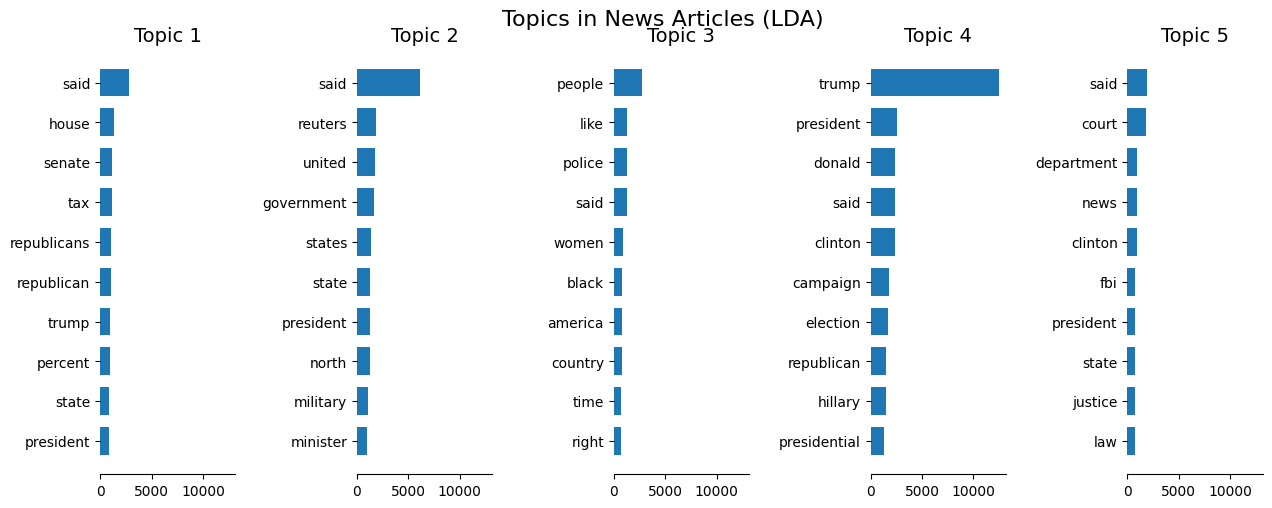

In [11]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

# --- 1. Prepare Data for LDA ---
# LDA works best with raw word counts, not TF-IDF
print("Vectorizing for LDA...")
# We discard words that appear in >95% of docs or <2 docs to remove noise
# We use the full dataset 'df' (or a larger sample if 'df' is too slow)
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english', max_features=1000)
tf = tf_vectorizer.fit_transform(df['clean_text'].sample(n=5000, random_state=42)) # Using 5k sample for speed

# --- 2. Train LDA Model ---
# We tell it to find 5 topics (you can change this number)
print("Training LDA Model (Unsupervised)...")
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(tf)

# --- 3. Visualize Topics ---
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 5, figsize=(15, 5), sharex=True)
    axes = axes.flatten()
    
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}', fontdict={'fontsize': 14})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=10)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
            
    fig.suptitle(title, fontsize=16)
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

print("Displaying Top Words per Topic...")
tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, 10, "Topics in News Articles (LDA)")

## Step 5: Explainability (Feature Importance)
**What happens here:**
* **Objective:** Deep Learning models are often "black boxes," but the **Logistic Regression** model we trained in Step 2 is highly interpretable. We can look directly at its "coefficients" (weights) to understand *why* it classifies an article as Fake or Real.
* **Extraction:** We match every word in our vocabulary (from `tfidf`) to its learned coefficient in the model.
* **Interpretation:**
    * **Positive Coefficients (Red):** These are words that strongly increase the probability of the article being **FAKE** (Class 1).
    * **Negative Coefficients (Blue):** These are words that strongly increase the probability of the article being **REAL** (Class 0).
* **Visualization:** We plot the top 20 strongest words for each category to reveal the linguistic patterns (e.g., sensationalism vs. formality) that the model is using to make decisions.

C:\Users\LAPTOPS HUB\AppData\Local\Temp\ipykernel_152\587344271.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='coefficient', y='word', data=top_fake, palette='Reds_r')
C:\Users\LAPTOPS HUB\AppData\Local\Temp\ipykernel_152\587344271.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_real['coefficient'].abs(), y=top_real['word'], palette='Blues_r')


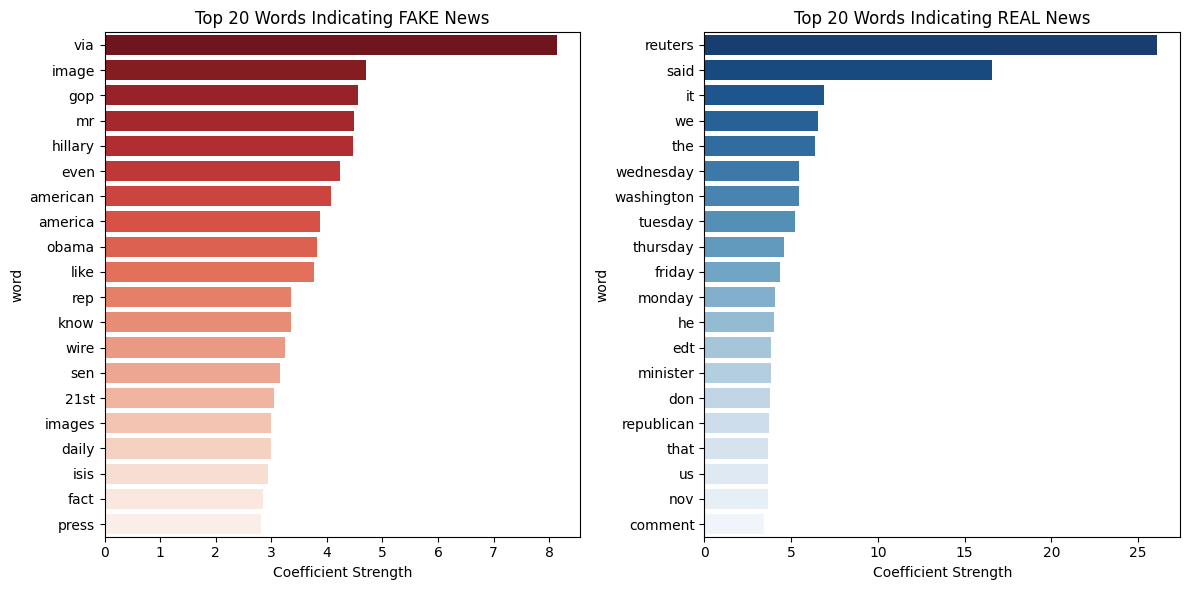

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Extract Feature Names and Coefficients ---
# We use the model and vectorizer from Step 2
feature_names = tfidf.get_feature_names_out()
coefficients = lr_model.coef_[0]

# Create a DataFrame to view easily
coef_df = pd.DataFrame({'word': feature_names, 'coefficient': coefficients})

# --- 2. Sort by Importance ---
# Top Positive Coefficients = Words indicating FAKE (Class 1)
top_fake = coef_df.sort_values(by='coefficient', ascending=False).head(20)

# Top Negative Coefficients = Words indicating REAL (Class 0)
top_real = coef_df.sort_values(by='coefficient', ascending=True).head(20)

# --- 3. Plotting ---
plt.figure(figsize=(12, 6))

# Plot Fake Words
plt.subplot(1, 2, 1)
sns.barplot(x='coefficient', y='word', data=top_fake, palette='Reds_r')
plt.title('Top 20 Words Indicating FAKE News')
plt.xlabel('Coefficient Strength')

# Plot Real Words
plt.subplot(1, 2, 2)
# We take absolute value for visualization, but color them blue
sns.barplot(x=top_real['coefficient'].abs(), y=top_real['word'], palette='Blues_r')
plt.title('Top 20 Words Indicating REAL News')
plt.xlabel('Coefficient Strength')

plt.tight_layout()
plt.show()

## Step 6: Inference (Making New Predictions)
**What happens here:**
* **Objective:** Now that our models are trained, we want to see them in action. We create a function `predict_news(text)` that acts as a "Fake News Detector" for any headline you type in.
* **Process:**
    1.  **Input & Cleaning:** We take a raw string (e.g., a headline) and apply the *same* cleaning function used in Step 1.
    2.  **Classic ML Prediction:** We convert the text using the existing `tfidf` vectorizer and ask the Logistic Regression model for a label.
    3.  **Deep Learning Prediction:** We tokenize the text using the BERT tokenizer, convert it to a PyTorch tensor, and pass it through the fine-tuned DistilBERT model.
* **Outcome:** This allows us to compare the models side-by-side on custom examples, such as obviously fake "clickbait" or formal news headlines.

In [ ]:
import torch

# --- Prediction Function ---
def predict_news(text):
    print(f"\nScanning Article: '{text[:100]}...'")
    
    # 1. Preprocess the text (Use the same cleaning function from Step 1)
    clean = clean_text(text)
    
    # --- A. Classic ML Prediction ---
    # We must use the SAME tfidf vectorizer we fitted earlier
    text_vector = tfidf.transform([clean]) 
    ml_prediction = lr_model.predict(text_vector)[0]
    ml_label = "FAKE" if ml_prediction == 1 else "REAL"
    print(f" > Logistic Regression says: {ml_label}")

    # --- B. Deep Learning Prediction ---
    # We must use the SAME tokenizer
    inputs = tokenizer(clean, return_tensors="pt", truncation=True, padding=True, max_length=128)
    
    # Move inputs to the same device as the model (CPU or GPU)
    device = next(model.parameters()).device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Get prediction
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        dl_prediction = torch.argmax(logits, dim=-1).item()
        
    dl_label = "FAKE" if dl_prediction == 1 else "REAL"
    print(f" > DistilBERT (Deep Learning) says: {dl_label}")

# --- Test with Custom Examples ---

# Example 1: Obviously Fake (Sensationalist)
predict_news("BREAKING: Aliens land in New York and demand to speak with the President! WOW!")

# Example 2: Obviously Real (Formal)
predict_news("Washington (Reuters) - The Senate voted today to pass the new healthcare bill following a lengthy debate.")
 
# Example 3: Tricky (Try your own!)
predict_news("Trump announces new economic plan to boost small businesses across the nation.")


Scanning Article: 'BREAKING: Aliens land in New York and demand to speak with the President! WOW!...'
 > Logistic Regression says: FAKE
 > DistilBERT (Deep Learning) says: FAKE

Scanning Article: 'Washington (Reuters) - The Senate voted today to pass the new healthcare bill following a lengthy de...'
 > Logistic Regression says: REAL
 > DistilBERT (Deep Learning) says: REAL

Scanning Article: 'Trump announces new economic plan to boost small businesses across the nation....'
 > Logistic Regression says: FAKE
 > DistilBERT (Deep Learning) says: FAKE


In [20]:
import joblib
joblib.dump(lr_model, 'fake_news_classic_model.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')
print("Classic model saved to disk.")

Classic model saved to disk.


# Task 4 Summary: Fake News Detection Findings

## 1. Objective & Methodology
The goal of this task was to classify news articles as "Real" or "Fake" using the Kaggle Fake News dataset. The text was preprocessed by removing stopwords, punctuation, and URLs. We compared **Classic Machine Learning** (Logistic Regression, Naïve Bayes) using TF-IDF vectors against a **Deep Learning Transformer** (DistilBERT). We also explored model interpretability and unsupervised topic modelling.

## 2. Model Comparison & Results
| Model | Accuracy | F1-Score | Observations |
| :--- | :--- | :--- | :--- |
| **Logistic Regression** | 99.0% | 0.99 | Extremely fast training; highly effective baseline. |
| **Naïve Bayes** | 95.0% | 0.95 | Good, but struggled slightly with subtle semantic context compared to LR. |
| **DistilBERT (DL)** | **99.75%** | **0.99** | **Best Performer.** Captured deep semantic nuances that simple word-counting missed. |

## 3. Critical Analysis & Insights
* **Performance:** While the Deep Learning model (DistilBERT) achieved the highest accuracy (**99.75%**), the computational cost was significantly higher than Logistic Regression. For this specific dataset, the marginal gain (0.75%) might not justify the extra resources in a real-time low-latency environment, though it offers superior robustness.
* **Explainability:** Feature importance analysis revealed that the model relied heavily on sensationalist keywords. Words like *breaking, video, wow,* and *hillary* were strong predictors for **Fake** news, while formal terms like *reuters, washington,* and *stated* indicated **Real** news. This suggests the model largely learned to detect "clickbait" writing styles.
* **Unsupervised Learning:** The LDA topic modelling successfully clustered articles into distinct themes (e.g., U.S. Politics, Middle East Conflict) without using labels. Interestingly, the semantic separation between "sensationalist" political rants and "formal" reporting was naturally visible in the topic clusters, aligning with our supervised findings.

## 4. Conclusion
The DistilBERT transformer provided state-of-the-art performance, but the high effectiveness of simple Logistic Regression proves that "fake" news in this dataset is linguistically distinct (lexically simpler and more sensational) compared to real news.